# CS4225/5425 Assignment 1

Note: first save your own copy of this Colab notebook (File > Save a copy in Drive), which should automatically open the copy, which you can then edit.

- **Your Name:** WEI YILEI
- **Your Student Number** (starting with A): A0276571W

How does text message communication differ between Singaporeans and Americans? A natural way to study this is to perform keyword analysis, to determine the words which are used preferentially by Singaporeans, as compared to by Americans.

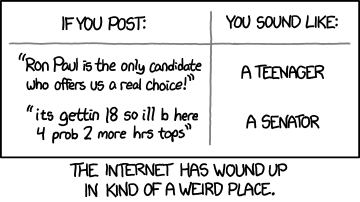
(Source: https://xkcd.com/1083/)

We will be using Hadoop Streaming, a variant of Hadoop. Before starting this assignment, go over Assignment 0 to familiarize with the basics of using Hadoop Streaming.

# Dataset

The data comes from the NUS SMS Corpus, consisting of messages collected around 2011, mostly originating from students attending the University (https://arxiv.org/abs/1112.2468). These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available.

Each dataset has multiple lines, each line representing a single message, and formatted as a JSON object (hence, they are "JSON Lines" files, with extension `.jsonl`). The large file has 55835 messages, while the small file has 5. The small file is optional to use, but may be useful for debugging (as it runs faster and you can more easily check the exact answers).

To help you understand the data format, the following shows the 1st message in the small dataset. The most important variables are the text message (`text`), and the `source` object, which contains user information about the message sender (`userProfile`). Note that the value associated with the `text` key is actually a JSON object, containing key "`$`", and the actual text as the value. The same is true for most of the other information in this data structure.

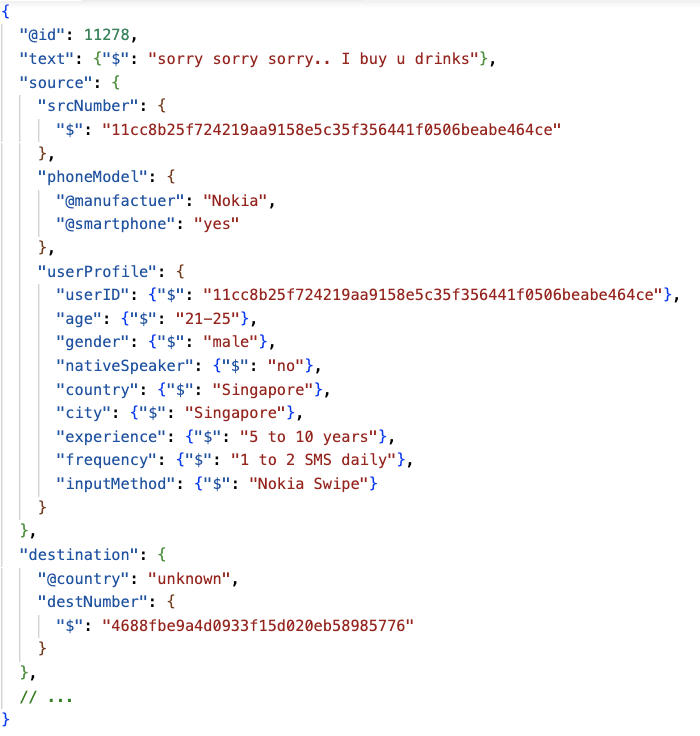

**Example 1**: A single message, stored as a JSON object. In the dataset, this message is represented as a single line (but is expanded here for clarity). `text` shows the actual message text, while the `country` the user is from is also recorded in the data.

# Task (40 marks)

Our goal is to identify keywords which are used much more by Singaporean users than by United States users. To be precise:
- We will consider "Singapore users" to be those with a `country` of "Singapore", exactly as shown in Example 1 above. Do not consider other forms like "SG", "singapore", "Singapore," and so on.
- Similarly, "United States users" refers to those with a `country` of "United States" exactly, no other forms.
- To extract "keywords", you only need to take each message text, and split it by whitespace (i.e., call the `split()` function without arguments on a line representing a message). Do not do any other text manipulations (e.g., changing the case, trimming or stripping spaces, removing punctuation, etc.) Of course, in realistic settings, all these steps could be considered, but here we need to ensure uniform results.

Given any keyword (for example, $\texttt{you}$), define the following:
- **Singapore Count:** $C_{S}(\texttt{you})$ is the number of occurrences of $\texttt{you}$ in messages by Singaporean users;
- **United States Count:** $C_{U}(\texttt{you})$ is the number of occurrences of $\texttt{you}$ in messages by United States users;
- **Total Count:** $T(\texttt{you}) = C_{S}(\texttt{you}) + C_{U}(\texttt{you})$ is the number of occurrences of $\texttt{you}$ in messages by Singaporean or United States users (do not include other country users);
- **Ratio:** $R_{S}(\texttt{you}) = C_{S}(\texttt{you}) / T(\texttt{you})$ is the Singaporean count divided by its total count.

The file `stopwords.txt` (downloaded below) contains stopwords, or un-informative words that we would like to ignore, like $\texttt{the}$.

Your task is as follows: for all **non-stopwords** with a Total Count of $\ge 500$, sort them in **decreasing order of their Ratio** (ties can be broken arbitrarily), and then print them one in each line, each with its Singaporean and United States count, separated by tabs. That is, each line in your output file should be of the form:

`<keyword>\t<Singapore Count>\t<United States Count>`

The file `sample_answer.txt` shows an example, which actually contains the first 5 lines of the correct answer, so you can later use this file to check the correctness of your program's output). As a sanity check, you should see words at the top which are preferentially used by Singaporeans, compared to those at the bottom.

**Submission.** Submit to Canvas a zip file containing your notebook (as a `.ipynb` file, which you can download via File > Download) and your final output file (called `part-00000`, which should be automatically produced by Hadoop and stored at `/content/output/part-00000` while running your Hadoop job). Save the zip file as `<your student number>`.zip, with your student number starting with A.

**Remarks.** Naturally, there are other interesting questions that could also be explored using this dataset: how about other dimensions like age, gender, or mobile phone brand (which are also in the dataset)? Or, we could also compare keywords in this corpus with regular text corpuses. However, for our actual assignment, to avoid issues due to multiple MapReduce jobs (like their files over-writing one another), we focus on just one precise task, particularly since this Colab version of the assignment is still new and being tested for now.

# Installing Hadoop

First, we need to download and install Hadoop to the `usr/local` directory, and then set the `JAVA_HOME` environment variable so Hadoop knows where to find Java on our system. The installation process should take 45 seconds or so. Note that if you refresh the colab notebook, you need to run this cell again before you can use Hadoop.

In [75]:
!wget https://dlcdn.apache.org/hadoop/common/hadoop-3.3.1/hadoop-3.3.1.tar.gz
!tar -xzf hadoop-3.3.1.tar.gz
# install hadoop to /usr/local
!cp -r hadoop-3.3.1/ /usr/local/
import os
# hadoop needs to know where java is located
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# the following line reduces the amount of Hadoop's printed output, to make it
# easier to see any errors, as well as your own debug output (which you can
# print to sys.stderr)
os.environ["HADOOP_ROOT_LOGGER"] = "WARN,console"

--2023-10-09 20:40:20--  https://dlcdn.apache.org/hadoop/common/hadoop-3.3.1/hadoop-3.3.1.tar.gz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 605187279 (577M) [application/x-gzip]
Saving to: ‘hadoop-3.3.1.tar.gz.1’

hadoop-3.3.1.tar.gz 100%[===================>] 577.15M   105MB/s    in 7.1s    

2023-10-09 20:40:51 (81.4 MB/s) - ‘hadoop-3.3.1.tar.gz.1’ saved [605187279/605187279]



# Downloading the Data

The data files are the small dataset (`sms_small.jsonl`), large dataset (`sms.jsonl`), a stopwords file (`stopwords.txt`) to be used later, and an example of the correct output format (`sample_output.txt`). Downloading them using `wget` stores them into the `/content/` directory.

In [76]:
!wget https://bhooi.github.io/teaching/cs4225/assign1/sms_small.jsonl
!wget https://bhooi.github.io/teaching/cs4225/assign1/sms.jsonl
!wget https://bhooi.github.io/teaching/cs4225/assign1/stopwords.txt
!wget https://bhooi.github.io/teaching/cs4225/assign1/sample_output.txt
!wget https://bhooi.github.io/teaching/cs4225/assign1/sms_20yo.jsonl

--2023-10-09 20:41:59--  https://bhooi.github.io/teaching/cs4225/assign1/sms_small.jsonl
Resolving bhooi.github.io (bhooi.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bhooi.github.io (bhooi.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4214 (4.1K) [application/octet-stream]
Saving to: ‘sms_small.jsonl.2’

sms_small.jsonl.2   100%[===================>]   4.12K  --.-KB/s    in 0s      

2023-10-09 20:41:59 (25.3 MB/s) - ‘sms_small.jsonl.2’ saved [4214/4214]

--2023-10-09 20:41:59--  https://bhooi.github.io/teaching/cs4225/assign1/sms.jsonl
Resolving bhooi.github.io (bhooi.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bhooi.github.io (bhooi.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45928744 (44M) [application/octet-stream]
Saving to: ‘sms.jsonl.2’

sms.jsonl.2         100%[===================>]  43.80M 

# Mapper and Reducer Code

Write your code for the mapper and reducer below. You may refer to Assignment 0 for an example of a working Hadoop Streaming program.

In [77]:
%%file mapper.py
import io
import sys

input_stream = io.TextIOWrapper(sys.stdin.buffer, encoding='latin1')

# Your code setting up data structures here if necessary (equivalent to setup() function)
f = open("stopwords.txt")
stop = f.readlines()
# print(stop, file = sys.stderr)
# print(stop[0], file = sys.stderr)
for i in range(len(stop)):
  stop[i] = stop[i].replace("\n", "")
# print(stop, file = sys.stderr)
# print(stop[0] == 'a', file = sys.stderr)

for line in input_stream:
  # Your code operating on each line here (equivalent to map() function)
  dic = eval(line)
  text = dic['text']['$']
  # print(text, file=sys.stderr)
  country = dic['source']['userProfile']['country']['$']
  # print(country, file=sys.stderr)
  if country == 'Singapore':
    for word in text.split():
      if word not in stop:
        print(f"{word}\t1")
      # print(f"{word}\t1", file=sys.stderr)
  elif country == 'United States':
    for word in text.split():
      if word not in stop:
        print(f"{word}\t2")
      # print(f"{word}\t2", file=sys.stderr)




# Your code for post-processing here if necessary (equivalent to cleanup() function)

# Like in Assignment 0, the output should be printed to sys.stdout, one line per tuple,
# separating the key and value by a tab.

Overwriting mapper.py


In [78]:
%%file reducer.py
import sys

# Your code setting up data structures here if necessary (equivalent to setup() function)
counts = {}

for line in sys.stdin:
  # Your code operating on each line here (more or less equivalent to reduce() function,
  # but only operating on a single tuple at a time)
  # print(line, file = sys.stderr)
  word, count = line.strip().split('\t')
  if int(count) == 1:
    if word not in counts:
      counts[word] = [0, 0, 0, 0]
    counts[word][0] += 1
  elif int(count) == 2:
    if word not in counts:
      counts[word] = [0, 0, 0, 0]
    counts[word][1] += 1



# Your code for post-processing here if necessary (equivalent to cleanup() function)
for word in list(counts.keys()):
  l = counts[word]
  number_s = l[0]
  number_u = l[1]
  total = number_s + number_u
  ratio_s = number_s / total
  if total < 500:
    del counts[word]
  else:
    counts[word][2] = total
    counts[word][3] = ratio_s
counts_order = sorted(counts.items(), key=lambda x:x[1][3], reverse = True)
for word, l in counts_order:
  print(f"{word}\t{l[0]}\t{l[1]}")
# Like in Assignment 0, the output should be printed to sys.stdout (the format should
# follow the required output format)

Overwriting reducer.py


# Run Hadoop Streaming

In [79]:
!chmod u+rwx /content/mapper.py
!chmod u+rwx /content/reducer.py

In [80]:
# Run Hadoop Streaming. You can replace sms.jsonl with the small dataset sms_small.jsonl
# for testing, and also modify the command, e.g. use -file to to add new files which your
# mappers or reducers may need access to.
!rm -rf /content/output
!/usr/local/hadoop-3.3.1/bin/hadoop jar /usr/local/hadoop-3.3.1/share/hadoop/tools/lib/hadoop-streaming-3.3.1.jar \
-input /content/sms.jsonl \
-output /content/output \
-file /content/mapper.py \
-file /content/reducer.py \
-file /content/stopwords.txt \
-mapper 'python mapper.py' \
-reducer 'python reducer.py'


2023-10-09 20:42:14,804 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/content/mapper.py, /content/reducer.py, /content/stopwords.txt] [] /tmp/streamjob1662649165086493996.jar tmpDir=null
2023-10-09 20:42:16,089 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-10-09 20:42:35,387 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!


In [81]:
# The output will be in the following file:
!cat /content/output/part-00000

(:	679	0
Haha.	746	0
dun	673	0
le	703	2
Hahaha	981	4
haha	979	4
ur	562	5
Haha	3300	57
Hey	609	29
U	677	36
meet	562	37
Ok	483	34
Oh	713	51
going	791	67
time	829	86
But	506	57
Yeah	504	60
I	9123	1173
Lol	989	128
<#>	2115	361
No	426	86
will	881	180
So	427	109
I'm	565	359


# Short-Answer Questions (10 marks)

**Note**: some of these questions may involve running your program with some slight modifications. As such, it is recommended that before doing these questions, you should save your previous answers file (i.e., download or rename your `/content/output/part-00000` file to use for submission)

1. State 2 optimizations which decrease the amount of data (e.g., in bytes) exchanged between the mappers and reducers for this program. Even small reductions are acceptable. (This question assumes you have not already made such optimizations; if you have, it is fine for your answer to include optimizations you have made).

<font color='blue'> (1) Optimization method 1: We uses a hash table “combine” to maintain the words and counts per line in each call to the map function. After processing each line it emits the counts for this line. This method will combine the same word count in each line, for example, we used to need to print twice (f"{word}\t1,1"), with this method, we only need print once (f"{word}\t1,{count}"), which will print(f"{word}\t1,2").; (2) Optimization method 2: In this approach, each mapper will use a hash table to maintain the words and counts across all lines in a single mapper. At the end of each mapper, the elements in hash table will be printed, equivalent to cleanup() function. By aggregating tuples across map tasks, this will obviously decrease the amount of data exchanged between the mappers and reducers for this program. </font>


2. By default, Hadoop (and Hadoop Streaming) uses 1 reducer (that is, 1 reduce task). In fact, you can increase the number of reducers by adding the argument: `-jobconf mapreduce.job.reduces=2` when running Hadoop Streaming. Try this out: how does it change the final outputs in the `/content/output/` directory? Explain why this occurs, by stating what data is received as input for each of the reducers.

<font color='blue'> The output retains only a fraction of the correct output (reduced from 24 to 15 lines), and after five runs, the output is the same each time. The reason is after the intermediate key-value pairs being shuffled and sorted by key, Hadoop will try to distribute them evenly between the two reducers based on the keys. So each reducer will only receive partial key-value pairs as input. For these pairs, the reducer should process them correctly and print correct answer. As a consequence, the output is a fraction of the correct output. To solve this problem, we should assemble the results of both reducers to get the final output. </font>

(Note that it is fine and expected that the program output when running with 2 reducers does not match the original task requirements; as long as your program output matches the requirements when using 1 reducer, it is considered correct. In practice, when running with multiple reducers, some simple post-processing could be added after getting the reducers' results to combine them into the final required form.)